### Time Series Forecasting using LSTM

In [1]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
from convert_columns_to_floats import *

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False



In [2]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
orig_df = pd.read_csv('/Users/faymajidelhassan/Downloads/Master project /Data/Weather/forecasts/open_weather.csv') 
df = orig_df.copy() 
print(f'Size of the dataset: {df.shape} \n')  
print() 
display(df.head(5))

Size of the dataset: (63132, 9) 




,timestamp,temperature,humidity,pressure,cloud_cover,wind_speed,wind_direction,weather_code,poprecipitation
0,2021-04-30 22:00:00,"[15.56, 15.26, 14.84, 14.2, 13.18, 12.13, 12.0...","[67, 69, 71, 74, 79, 84, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[0, 18, 34, 60, 57, 75, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [800, 801, 802, 803, 803, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, ..."
1,2021-04-30 22:15:00,"[15.56, 15.26, 14.84, 14.2, 13.18, 12.13, 12.0...","[67, 69, 71, 74, 79, 84, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[0, 18, 34, 60, 57, 75, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [800, 801, 802, 803, 803, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, ..."
2,2021-04-30 22:30:00,"[15.36, 15.56, 15.2, 14.65, 13.78, 12.82, 12.0...","[69, 67, 69, 72, 76, 81, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[18, 0, 17, 40, 43, 60, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [801, 800, 801, 802, 802, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, ..."
3,2021-04-30 22:45:00,"[15.28, 15.47, 15.13, 14.6, 13.74, 12.8, 12.08...","[73, 72, 73, 75, 78, 82, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[18, 0, 17, 40, 43, 60, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [801, 800, 801, 802, 802, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, ..."
4,2021-04-30 23:00:00,"[15.48, 15.13, 14.6, 13.75, 12.8, 12.08, 13.32...","[72, 73, 75, 78, 82, 85, 81, 73, 66, 61, 56, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1011, 101...","[0, 17, 40, 43, 60, 81, 85, 86, 100, 100, 100,...","[1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84, 0.54,...","[242, 243, 221, 230, 223, 231, 229, 221, 239, ...","{'id': [800, 801, 802, 802, 803, 803, 804, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0.2..."


In [4]:
# reduce memory usage
df= reduce_mem_usage(df)

Mem. usage decreased to  4.34 Mb (0.0% reduction)


In [5]:
df

,timestamp,temperature,humidity,pressure,cloud_cover,wind_speed,wind_direction,weather_code,poprecipitation
0,2021-04-30 22:00:00,"[15.56, 15.26, 14.84, 14.2, 13.18, 12.13, 12.0...","[67, 69, 71, 74, 79, 84, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[0, 18, 34, 60, 57, 75, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [800, 801, 802, 803, 803, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, ..."
1,2021-04-30 22:15:00,"[15.56, 15.26, 14.84, 14.2, 13.18, 12.13, 12.0...","[67, 69, 71, 74, 79, 84, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[0, 18, 34, 60, 57, 75, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [800, 801, 802, 803, 803, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, ..."
2,2021-04-30 22:30:00,"[15.36, 15.56, 15.2, 14.65, 13.78, 12.82, 12.0...","[69, 67, 69, 72, 76, 81, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[18, 0, 17, 40, 43, 60, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [801, 800, 801, 802, 802, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, ..."
3,2021-04-30 22:45:00,"[15.28, 15.47, 15.13, 14.6, 13.74, 12.8, 12.08...","[73, 72, 73, 75, 78, 82, 85, 81, 73, 66, 61, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[18, 0, 17, 40, 43, 60, 81, 85, 86, 100, 100, ...","[1.72, 1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84,...","[252, 242, 243, 221, 230, 223, 231, 229, 221, ...","{'id': [801, 800, 801, 802, 802, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, ..."
4,2021-04-30 23:00:00,"[15.48, 15.13, 14.6, 13.75, 12.8, 12.08, 13.32...","[72, 73, 75, 78, 82, 85, 81, 73, 66, 61, 56, 5...","[1010, 1010, 1010, 1010, 1010, 1010, 1011, 101...","[0, 17, 40, 43, 60, 81, 85, 86, 100, 100, 100,...","[1.5, 1.94, 1.8, 1.66, 1.28, 1.15, 0.84, 0.54,...","[242, 243, 221, 230, 223, 231, 229, 221, 239, ...","{'id': [800, 801, 802, 802, 803, 803, 804, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0.2..."
...,...,...,...,...,...,...,...,...,...
63127,2023-02-17 11:45:00,"[14.06, 14.7, 14.38, 14.18, 13.6, 12.12, 10.1,...","[53, 51, 52, 53, 56, 63, 72, 75, 78, 79, 81, 8...","[1026, 1026, 1026, 1026, 1025, 1025, 1026, 102...","[2, 0, 8, 19, 30, 39, 55, 60, 64, 77, 82, 75, ...","[2.9, 3.28, 3.52, 3.39, 3.19, 3.24, 3.03, 3, 2...","[238, 240, 242, 245, 241, 235, 235, 236, 237, ...","{'id': [800, 800, 800, 801, 802, 802, 803, 803...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
63128,2023-02-17 12:00:00,"[14.8, 14.46, 14.24, 13.64, 12.14, 10.1, 9.32,...","[51, 52, 53, 56, 63, 72, 75, 78, 79, 81, 83, 8...","[1026, 1026, 1026, 1025, 1025, 1026, 1026, 102...","[0, 8, 19, 30, 39, 55, 60, 64, 77, 82, 75, 65,...","[3.28, 3.52, 3.39, 3.19, 3.24, 3.03, 3, 2.92, ...","[240, 242, 245, 241, 235, 235, 236, 237, 243, ...","{'id': [800, 800, 801, 802, 802, 803, 803, 803...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
63129,2023-02-17 12:15:00,"[15.76, 15.1, 14.58, 13.72, 11.78, 9.18, 8.67,...","[48, 51, 55, 59, 67, 78, 79, 80, 81, 84, 86, 8...","[1025, 1025, 1025, 1025, 1025, 1026, 1026, 102...","[0, 16, 33, 45, 62, 78, 81, 90, 90, 71, 61, 52...","[4.23, 4.42, 3.79, 3.71, 3.5, 3.24, 3.39, 3.48...","[242, 242, 242, 239, 236, 234, 230, 236, 243, ...","{'id': [800, 801, 802, 802, 803, 803, 803, 804...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
63130,2023-02-17 12:30:00,"[15.13, 15.78, 15.34, 14.65, 13.22, 11.28, 9.2...","[50, 48, 50, 53, 59, 68, 76, 78, 79, 81, 83, 8...","[1025, 1025, 1025, 1025, 1025, 1026, 1026, 102...","[5, 0, 9, 15, 24, 35, 50, 64, 66, 59, 54, 47, ...","[3.35, 3.61, 3.55, 3.35, 3.36, 3.23, 3.02, 3.0...","[239, 240, 246, 241, 233, 237, 241, 234, 239, ...

In [6]:
# Convert specific columns to lists of floats
# columns_to_convert1 = [
#     'temperature', 'humidity', 'pressure',	'cloud_cover',	'wind_speed',
#         	'wind_direction',	'weather_code'	,'poprecipitation'
# ]

columns_to_convert2 = [
    'temperature', 'humidity', 'pressure',
    'cloud_cover', 'wind_speed', 'wind_direction', 'poprecipitation',
     'weather_code'
]
def parse_complex_string(s):
    try:
        return [float(x) for x in s.strip('[]').split(',')]
    except ValueError:
        return s

# Function to convert columns to lists of floats
def convert_columns_to_numeric_lists(df, columns_to_convert):
    for col in columns_to_convert:
        df[col] = df[col].astype(str).apply(parse_complex_string)
    return df

def convert_columns_to_floats2(df, columns_to_convert):
    for col in columns_to_convert:
        print(f"Processing column: {col}")
        df[col] = df[col].astype(str).apply(parse_complex_string)
        print(f"Processed column: {col}")
    return df

def flatten_columns(df, columns_to_flatten):
    for col in columns_to_flatten:
        df[col] = df[col].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
    return df
def reduce_cells_for_all_columns(df, columns_to_reduce,n=int):
    '''
    Reduce each cell in each column by 96 values from the end
    '''
    for cols in columns_to_reduce:
        df[cols] = df[cols].apply(lambda x: x[:-n])
    return df
def get_lengths_of_cells(df, columns):
    '''
    Get the lengths of cells in each specified column
    '''
    lengths = {col: df[col].apply(lambda x: len(x) if isinstance(x, list) else np.nan) for col in columns}
    return pd.DataFrame(lengths)
df = convert_columns_to_numeric_lists(df, columns_to_convert2)
# df= convert_columns_to_floats2(df, columns_to_convert2)
# lengths_df = get_lengths_of_cells(df, columns_to_convert2)

# print("Lengths of cells before reduction:")
# print(lengths_df)
# df = convert_columns_to_floats2(df, columns_to_convert1)

# # Flatten the columns
# # df= reduce_cells_for_all_columns(df,columns_to_convert2,n=72)
# # df = flatten_columns(df, columns_to_convert1)
# df = flatten_columns(df, columns_to_convert2)

In [7]:
# Function to aggregate list features
def aggregate_features(df, columns_to_aggregate):
    for col in columns_to_aggregate:
        df[f'{col}_mean'] = df[col].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
        df[f'{col}_std'] = df[col].apply(lambda x: np.std(x) if isinstance(x, list) else 0)
        df[f'{col}_min'] = df[col].apply(lambda x: np.min(x) if isinstance(x, list) else x)
        df[f'{col}_max'] = df[col].apply(lambda x: np.max(x) if isinstance(x, list) else x)
        # Drop original column if not needed
        df.drop(columns=[col], inplace=True)
    return df

# Aggregate the columns
df = aggregate_features(df, columns_to_convert2)

print("\nDataFrame with aggregated features:")
print(df)



DataFrame with aggregated features:
                 timestamp  temperature_mean  temperature_std  \
0      2021-04-30 22:00:00         16.681875         3.221399   
1      2021-04-30 22:15:00         16.681875         3.221399   
2      2021-04-30 22:30:00         16.727708         3.178263   
3      2021-04-30 22:45:00         16.720417         3.182403   
4      2021-04-30 23:00:00         16.599375         3.342048   
...                    ...               ...              ...   
63127  2023-02-17 11:45:00          8.907292         2.547870   
63128  2023-02-17 12:00:00          8.873958         2.494861   
63129  2023-02-17 12:15:00          9.014375         2.622159   
63130  2023-02-17 12:30:00          8.881875         2.696836   
63131  2023-02-17 12:45:00          8.938958         2.825328   

       temperature_min  temperature_max  humidity_mean  humidity_std  \
0                 9.92            22.97      71.812500     17.626514   
1                 9.92            22.9

In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resample and aggregate the data to every 5 minutes
df = df.resample('5T').agg({
    'temperature_mean': 'mean', 'temperature_std': 'mean', 'temperature_min': 'mean', 'temperature_max': 'mean',
    'humidity_mean': 'mean', 'humidity_std': 'mean', 'humidity_min': 'mean', 'humidity_max': 'mean',
    'pressure_mean': 'mean', 'pressure_std': 'mean', 'pressure_min': 'mean', 'pressure_max': 'mean',
    'cloud_cover_mean': 'mean', 'cloud_cover_std': 'mean', 'cloud_cover_min': 'mean', 'cloud_cover_max': 'mean',
    'wind_speed_mean': 'mean', 'wind_speed_std': 'mean', 'wind_speed_min': 'mean', 'wind_speed_max': 'mean',
    'wind_direction_mean': 'mean', 'wind_direction_std': 'mean', 'wind_direction_min': 'mean', 'wind_direction_max': 'mean',
    'poprecipitation_mean': 'sum', 'poprecipitation_std': 'sum', 'poprecipitation_min': 'sum', 'poprecipitation_max': 'sum',
    'weather_code_mean': 'sum', 'weather_code_std': 'sum', 'weather_code_min': 'sum', 'weather_code_max': 'sum'
})

df.head()
df.isnull().sum()
df = df.fillna(method='ffill')
df.head()

,temperature_mean,temperature_std,temperature_min,temperature_max,humidity_mean,humidity_std,humidity_min,humidity_max,pressure_mean,pressure_std,...,wind_direction_min,wind_direction_max,poprecipitation_mean,poprecipitation_std,poprecipitation_min,poprecipitation_max,weather_code_mean,weather_code_std,weather_code_min,weather_code_max
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-04-30 22:00:00,16.681875,3.221399,9.92,22.97,71.8125,17.626514,46.0,99.0,1008.3125,2.381843,...,44.0,252.0,0.343125,0.372912,0.0,1.0,"{'id': [800, 801, 802, 803, 803, 803, 803, 804...",0.0,"{'id': [800, 801, 802, 803, 803, 803, 803, 804...","{'id': [800, 801, 802, 803, 803, 803, 803, 804..."
2021-04-30 22:05:00,16.681875,3.221399,9.92,22.97,71.8125,17.626514,46.0,99.0,1008.3125,2.381843,...,44.0,252.0,0.000000,0.000000,0.0,0.0,0,0.0,0,0
2021-04-30 22:10:00,16.681875,3.221399,9.92,22.97,71.8125,17.626514,46.0,99.0,1008.3125,2.381843,...,44.0,252.0,0.000000,0.000000,0.0,0.0,0,0.0,0,0
2021-04-30 22:15:00,16.681875,3.221399,9.92,22.97,71.8125,17.626514,46.0,99.0,1008.3125,2.381843,...,44.0,252.0,0.343125,0.372912,0.0,1.0,"{'id': [800, 801, 802, 803, 803, 803, 803, 804...",0.0,"{'id': [800, 801, 802, 803, 803, 803, 803, 804...","{'id': [800, 801, 802, 803, 803, 803, 803, 804..."
2021-04-30 22:20:00,16.681875,3.221399,9.92,22.97,71.8125,17.626514,46.0,99.0,1008.3125,2.381843,...,44.0,252.0,0.000000,0.000000,0.0,0.0,0,0.0,0,0


In [ ]:
# # Convert timestamp to datetime and set as index
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df.set_index('timestamp', inplace=True)

# # Fill missing values using forward fill
# # df = df.fillna(method='ffill')

# # # Plot univariate data (temperature)
# # uni_data = df['temperature']
# # uni_data.plot()

# # Resample and aggregate the data
# df = df.resample('10T').agg({
#     'temperature': 'mean',  
#     'humidity': 'mean',     
#     'pressure': 'mean',  
    
#     'cloud_cover': 'mean',
#     'wind_speed': 'mean',
#     'wind_direction': 'mean',
#     'poprecipitation': 'sum',
    
#     'weather_code': 'sum'
# })



In [9]:
# Prepare the univariate model for temperature using all temperature-related features
temperature_features = df[['temperature_mean', 'temperature_std', 'temperature_min', 'temperature_max']]
uni_data_temp = temperature_features.values
train_split = int(len(uni_data_temp) * 0.8)
tf.random.set_seed(13)

# Standardize data
uni_data_temp_mean = uni_data_temp[:train_split].mean(axis=0)
uni_data_temp_std = uni_data_temp[:train_split].std(axis=0)
uni_data_temp = (uni_data_temp - uni_data_temp_mean) / uni_data_temp_std

# Function to create data for univariate forecasting
def univariate_data(dataset, start_idx, end_idx, history_size, target_size):
    data = []
    labels = []
    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size
    for i in range(start_idx, end_idx):
        idxs = range(i - history_size, i)
        data.append(dataset[idxs])
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

uni_data_history = 20  # Last 20 values
uni_data_future = 0    # Future data

x_train_uni_temp, y_train_uni_temp = univariate_data(uni_data_temp, 0, train_split, uni_data_history, uni_data_future)
x_val_uni_temp, y_val_uni_temp = univariate_data(uni_data_temp, train_split, None, uni_data_history, uni_data_future)

print(x_train_uni_temp.shape)
print(y_train_uni_temp.shape)
print(x_val_uni_temp.shape)
print(y_val_uni_temp.shape)

(151495, 20, 4)
(151495, 4)
(37859, 20, 4)
(37859, 4)


Observations:
1) One reading evrry 10 mins (from datatime column time diff for every record )
2) 1day = 6*24 = 144 readings
Task : Forecasting Temperature(in degree ) in future 




(151495, 20, 4)
(151495, 4)
(37859, 20, 4)
(37859, 4)


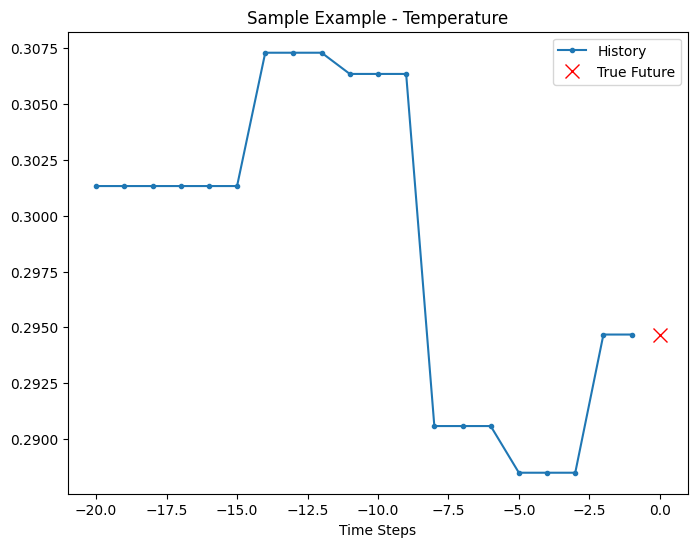

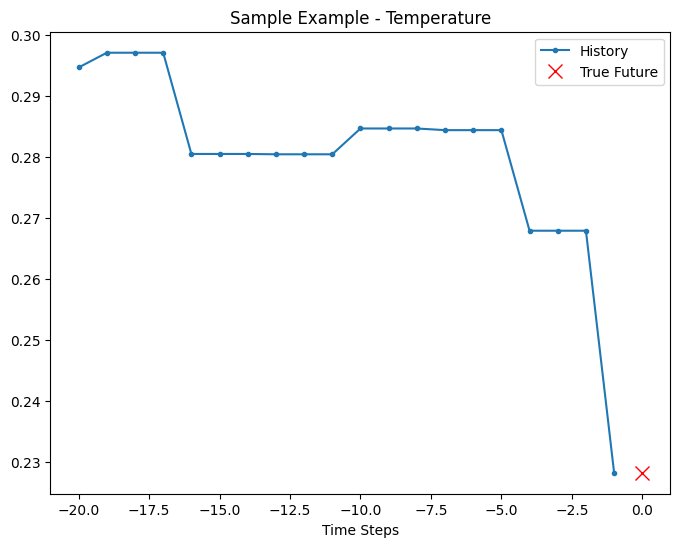

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Assume df is your DataFrame and it's already loaded
# Prepare the univariate model for temperature using all temperature-related features
temperature_features = df[['temperature_mean', 'temperature_std', 'temperature_min', 'temperature_max']]
uni_data_temp = temperature_features.values
train_split = int(len(uni_data_temp) * 0.8)
tf.random.set_seed(13)

# Standardize data
uni_data_temp_mean = uni_data_temp[:train_split].mean(axis=0)
uni_data_temp_std = uni_data_temp[:train_split].std(axis=0)
uni_data_temp = (uni_data_temp - uni_data_temp_mean) / uni_data_temp_std

# Function to create data for univariate forecasting
def univariate_data(dataset, start_idx, end_idx, history_size, target_size):
    data = []
    labels = []
    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size
    for i in range(start_idx, end_idx):
        idxs = range(i - history_size, i)
        data.append(dataset[idxs])
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

uni_data_history = 20  # Last 20 values
uni_data_future = 0    # Future data

x_train_uni_temp, y_train_uni_temp = univariate_data(uni_data_temp, 0, train_split, uni_data_history, uni_data_future)
x_val_uni_temp, y_val_uni_temp = univariate_data(uni_data_temp, train_split, None, uni_data_history, uni_data_future)

print(x_train_uni_temp.shape)  # (151495, 20, 4)
print(y_train_uni_temp.shape)  # (151495, 4)
print(x_val_uni_temp.shape)    # (37859, 20, 4)
print(y_val_uni_temp.shape)    # (37859, 4)

# Function to create time steps
def create_time_steps(length):
    return list(range(-length, 0))

# Function to plot time series data
def plot_time_series(plot_data, delta, title):
    labels = ["History", "True Future", "Model Predicted"]
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i == 0:
            plt.plot(time_steps, plot_data[i][:, 0], marker[i], label=labels[i])  # Plot only the first feature for simplicity
        else:
            future = time_steps[-1] + 1
            plt.plot([future], plot_data[i], marker[i], markersize=10, label=labels[i])  # Plot single future point
    plt.legend()
    plt.xlabel('Time Steps')
    plt.show()

# Example of plotting the first sample
plot_time_series([x_train_uni_temp[0], y_train_uni_temp[0][0]], 0, 'Sample Example - Temperature')

# Example of plotting another sample
i = 20
plot_time_series([x_train_uni_temp[i], y_train_uni_temp[i][0]], 0, 'Sample Example - Temperature')



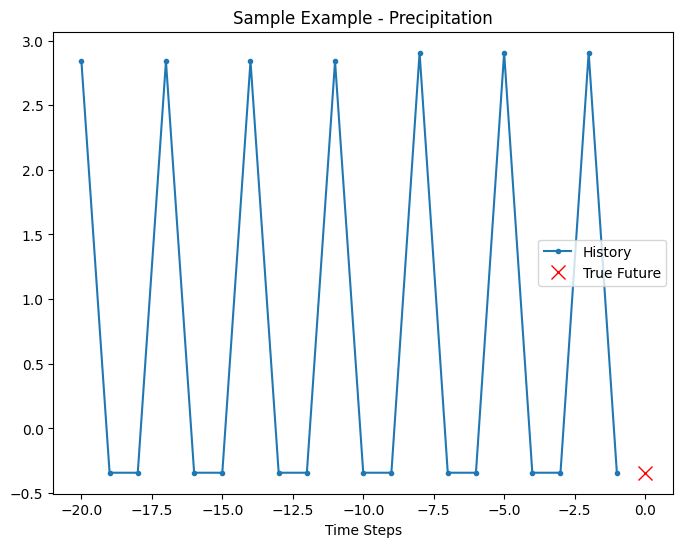

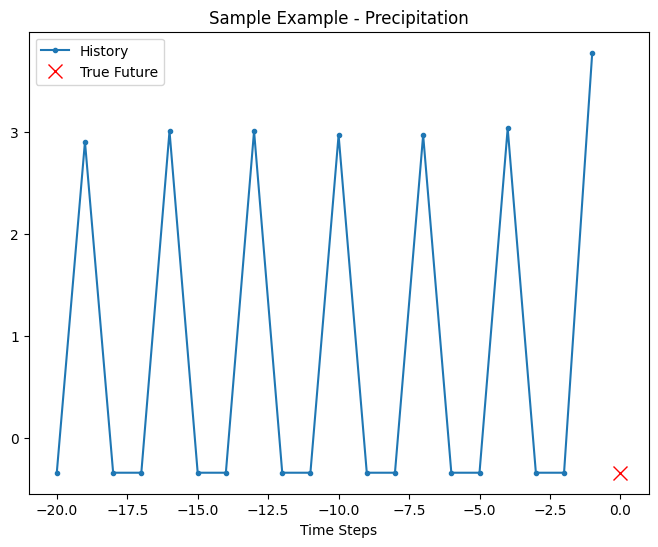

In [11]:
# Prepare the univariate model for precipitation using all precipitation-related features
precipitation_features = df[['poprecipitation_mean', 'poprecipitation_std', 'poprecipitation_min', 'poprecipitation_max']]
uni_data_precip = precipitation_features.values

# Standardize data
uni_data_precip_mean = uni_data_precip[:train_split].mean(axis=0)
uni_data_precip_std = uni_data_precip[:train_split].std(axis=0)
uni_data_precip = (uni_data_precip - uni_data_precip_mean) / uni_data_precip_std

x_train_uni_precip, y_train_uni_precip = univariate_data(uni_data_precip, 0, train_split, uni_data_history, uni_data_future)
x_val_uni_precip, y_val_uni_precip = univariate_data(uni_data_precip, train_split, None, uni_data_history, uni_data_future)
x_train_uni_precip.shape, y_train_uni_precip.shape
x_val_uni_precip.shape, y_val_uni_precip.shape

plot_time_series([x_train_uni_precip[0], y_train_uni_precip[0][0]], 0, 'Sample Example - Precipitation')
i = 20
plot_time_series([x_train_uni_precip[i], y_train_uni_precip[i][0]], 0, 'Sample Example - Precipitation')


In [12]:
# Prepare tensorflow dataset for univariate temperature model
batch_size = 256
buffer_size = 10000

train_uni_temp = tf.data.Dataset.from_tensor_slices((x_train_uni_temp, y_train_uni_temp))
train_uni_temp = train_uni_temp.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni_temp = tf.data.Dataset.from_tensor_slices((x_val_uni_temp, y_val_uni_temp))
val_uni_temp = val_uni_temp.cache().shuffle(buffer_size).batch(batch_size).repeat()

# Prepare tensorflow dataset for univariate precipitation model
train_uni_precip = tf.data.Dataset.from_tensor_slices((x_train_uni_precip, y_train_uni_precip))
train_uni_precip = train_uni_precip.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni_precip = tf.data.Dataset.from_tensor_slices((x_val_uni_precip, y_val_uni_precip))
val_uni_precip = val_uni_precip.cache().shuffle(buffer_size).batch(batch_size).repeat()


In [13]:
# Define LSTM model for temperature
lstm_model_temp = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni_temp.shape[-2:]),
    tf.keras.layers.Dense(1)
])
lstm_model_temp.compile(optimizer='adam', loss='mae')
lstm_model_temp.summary()

# Train LSTM model for temperature
EVALUATION_INTERVAL = 200
EPOCHS = 10
temp_history = lstm_model_temp.fit(train_uni_temp, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                   validation_data=val_uni_temp, validation_steps=50)


/Users/faymajidelhassan/anaconda3/envs/m/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8)              │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425 (1.66 KB)

 Trainable params: 425 (1.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3755 - val_loss: 0.3688
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2163 - val_loss: 0.2441
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2055 - val_loss: 0.2628
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2373 - val_loss: 0.2958
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1852 - val_loss: 0.2435
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1990 - val_loss: 0.2260
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2282 - val_loss: 0.2857
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1838 - val_loss: 0.2381
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1973 - val_loss: 0.2250
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2174 - val_loss: 0.2822


In [14]:
mae_lstm_single = lstm_model_temp.evaluate(val_uni_temp, steps=100)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2910


In [15]:
# Define LSTM model for precipitation
lstm_model_precip = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_uni_precip.shape[-2:]),
    tf.keras.layers.Dense(1)
])
lstm_model_precip.compile(optimizer='adam', loss='mae')
lstm_model_precip.summary()

# Train LSTM model for precipitation
precip_history = lstm_model_precip.fit(train_uni_precip, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                       validation_data=val_uni_precip, validation_steps=50)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,769 (18.63 KB)

 Trainable params: 4,769 (18.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2532 - val_loss: 0.4170
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3649 - val_loss: 0.3251
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2998 - val_loss: 0.2518
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1739 - val_loss: 0.2724
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2459 - val_loss: 0.3017
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2896 - val_loss: 0.2523
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1750 - val_loss: 0.2740
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2407 - val_loss: 0.3008
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2858 - val_loss: 0.2457
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1798 - val_loss: 0.2774


In [16]:
mae_lstm_single = lstm_model_precip.evaluate(val_uni_precip, steps=100)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2551


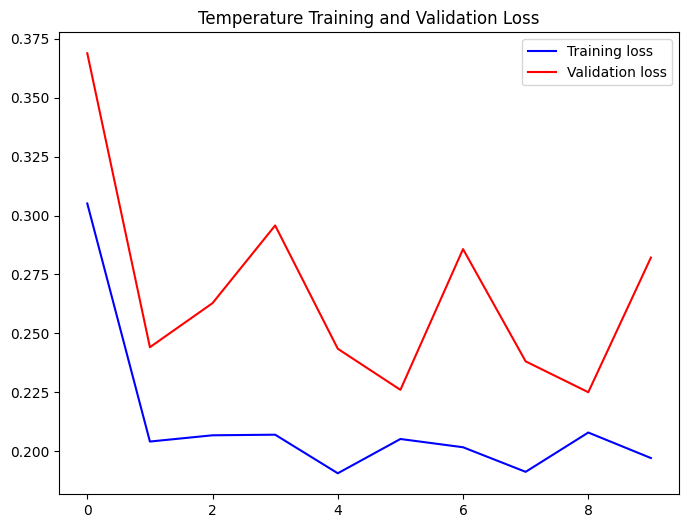

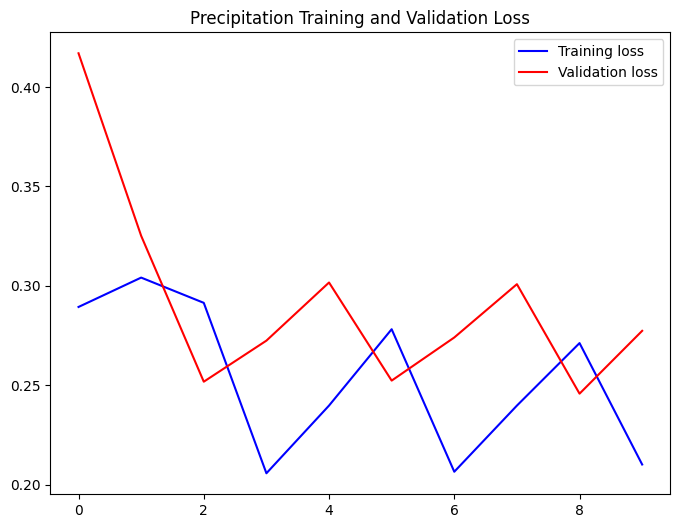

In [17]:
# Plotting function for training history
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(temp_history, 'Temperature Training and Validation Loss')
plot_train_history(precip_history, 'Precipitation Training and Validation Loss')


In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assuming the variables like train_split, buffer_size, batch_size, create_time_steps are defined appropriately

# Multivariate model using selected features
features = [
    'temperature_mean', 'temperature_std', 'temperature_min', 'temperature_max',
    'humidity_mean', 'humidity_std', 'humidity_min', 'humidity_max',
    'poprecipitation_mean', 'poprecipitation_std', 'poprecipitation_min', 'poprecipitation_max'
]

# Filter the DataFrame to include only the selected features
multi_features = df[features].values

# Normalize the features
multi_data_mean = multi_features[:train_split].mean(axis=0)
multi_data_std = multi_features[:train_split].std(axis=0)
multi_features = (multi_features - multi_data_mean) / multi_data_std

# Function to create multivariate data
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    end_index = end_index if end_index is not None else len(dataset) - target_size
    start_index = start_index + history_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])

    return np.array(data), np.array(labels)

history_size = 1440
target_size = 144
STEP = 6

# Create training and validation data
x_train_multi, y_train_multi = multivariate_data(multi_features, multi_features[:, 0], 0, train_split, history_size, target_size, STEP, single_step=True)
x_val_multi, y_val_multi = multivariate_data(multi_features, multi_features[:, 0], train_split, None, history_size, target_size, STEP, single_step=True)

# Create TensorFlow datasets
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

# Multivariate LSTM model
multi_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.LSTM(16, return_sequences=False, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),  # Additional dense layer if needed
    tf.keras.layers.Dense(target_size)  # Output layer predicting 144 time steps into the future
])

multi_step_model.compile(optimizer='adam', loss='mae')

# Verify model output shape
for x, y in val_data_multi.take(1):
    print("Model Output Shape:", multi_step_model.predict(x).shape)

# Define training parameters
EVALUATION_INTERVAL = 200
EPOCHS = 10

# Train the model
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi, validation_steps=50)

# Plot training history
plot_train_history(multi_step_history, 'Multi-Step Training and Validation Loss')

# Plot some predictions
for x, y in val_data_multi.take(5):
    plot_time_series([x[0][:, 0].numpy(), y[0].numpy(), multi_step_model.predict(x)], 0, 'LSTM Multi-Step')


: 

In [ ]:
mae_lstm_single = multi_step_model.evaluate(val_uni_multi, steps=100)

NameError: name 'val_uni_multi' is not defined

Moving Window Average


1.   Given last 20 values of observations(temp) , predict next observation
2.   MWA: predict== AVG(last 20 values)




In [ ]:
## utility functions

## funtion to create data for univariate forecasting

def univariate_data(dataset, start_idx , end_idx , history_size, target_size):
  data = []
  labels = []
  start_idx  = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx):
    idxs = range(i-history_size , i)
    data.append(np.reshape(dataset[idxs] , (history_size, 1))) ### reshape data
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

uni_data_history = 20   ## last 50 values
uni_data_future = 0     ## future data

x_train_uni , y_train_uni = univariate_data(uni_data , 0 , train_split , uni_data_history , uni_data_future)

x_val_uni , y_val_uni = univariate_data(uni_data , train_split , None ,uni_data_history , uni_data_future)

In [ ]:
x_train_uni

In [ ]:
print(x_train_uni.shape , y_train_uni.shape)
print(x_val_uni.shape , y_val_uni.shape)

In [ ]:
print('Single window of history data' , x_train_uni[0])

print('Target Temperature to predict ' , y_train_uni[0])


In [ ]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt
## function to plot time series data



plot_time_series([x_train_uni[0] , y_train_uni[0]] , 0 , 'Sample Example')

In [ ]:
i = 20
plot_time_series([x_train_uni[i], y_train_uni[i]] , 0 , 'Sample Example')

In [ ]:
### Moving window average

def MWA(history):
  return np.mean(history)




In [ ]:
i = 20
plot_time_series([x_train_uni[i] , y_train_uni[i] , MWA(x_train_uni[i])] , 0 , 'MWA predicted')

Univariate time-series forecasting


*   Only single feature as temperature(historical data)
*   Task:  Given last 20 observations(history) , predict next temperature value 



In [ ]:
## prepare tensorflow dataset
batch_size = 256
buffer_size = 10000

train_uni = tf.data.Dataset.from_tensor_slices((x_train_uni , y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni = tf.data.Dataset.from_tensor_slices((x_val_uni , y_val_uni))
val_uni = val_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_uni)
print(val_uni)

In [ ]:
## Define LSTM model 

lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(8 , input_shape = x_train_uni.shape[-2:]), 
                                         tf.keras.layers.Dense(1)])

lstm_model.compile(optimizer = 'adam', loss = 'mae')

steps = 200

EPOCHS =10

lstm_model.fit(train_uni , epochs = EPOCHS, steps_per_epoch = steps ,
               validation_data = val_uni, validation_steps = 50)




In [ ]:
for i , j in val_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , lstm_model.predict(i)[0]] ,0 , 'LSTM UNIVARIATE')
  plot.show()

Multivariate  and Single step Forecasting


*   Task: Given 3 features(temp , pressure , and density) at each time step can we predict the temp in future at single time step




In [ ]:
## features 

# features_6 = ['temperature', 'humidity', 'pressure', 'global_irradiance', 'direct_irradiance', 'diffuse_irradiance']
features14 = [
    'temperature', 'humidity', 'pressure',
    'cloud_cover', 'wind_speed', 'wind_direction', 'poprecipitation'
]
features = df[features14]
features.head()



In [ ]:
features.isnull().sum()
features=features.fillna(features.mean())

In [ ]:
features.plot(subplots=True)

In [ ]:
# ### standardize data
dataset = features.values
# dataset = np.array(features)
data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std



In [ ]:
# # ### create mutlivariate data

# def multivariate_data(dataset, target, start_idx, end_idx, history_size, target_size, step, single_step=False):
#     data, labels = [], []
#     start_idx += history_size
#     if end_idx is None:
#         end_idx = len(dataset) - target_size
#     for i in range(start_idx, end_idx):
#         indices = range(i-history_size, i, step)
#         data.append(dataset[indices])
#         if single_step:
#             labels.append(target[i+target_size])
#         else:
#             labels.append(target[i:i+target_size])
#     return np.array(data), np.array(labels)
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    # Adjust end_index to avoid out-of-bounds error
    end_index = end_index if end_index is not None else len(dataset) - target_size
    
    # Adjust start_index to accommodate history_size
    start_index = start_index + history_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    
    return np.array(data), np.array(labels)


In [ ]:
# ### generate multivariate data
from sklearn.preprocessing import StandardScaler
# history = 720
# future_target = 72
# STEP = 6

# x_train_ss, y_train_ss = multivariate_data(dataset, dataset[:, 1], 0, train_split, history,
#                                            future_target, STEP, single_step=True)


# x_val_ss , y_val_ss = multivariate_data(dataset , dataset[:,1] , train_split , None , history,
#                                         future_target, STEP, single_step = True)


# print(x_train_ss.shape , y_train_ss.shape)
# Define your parameters
# Define your parameters
history = 720
future_target = 72
STEP = 6
train_split = int(len(dataset) * 0.7)
# scaler = StandardScaler()
# scaler.fit(dataset[:train_split])

# # Transform the entire dataset
# dataset = scaler.transform(dataset)
# Get training data
x_train_ss, y_train_ss = multivariate_data(dataset, dataset[:, 1], 0, train_split, history, future_target, STEP, single_step=True)

# Get validation data
x_val_ss, y_val_ss = multivariate_data(dataset, dataset[:, 1], train_split, None, history, future_target, STEP, single_step=True)

# Check shapes
print(x_train_ss.shape, y_train_ss.shape)
print(x_val_ss.shape, y_val_ss.shape)



In [ ]:
x_train_ss

In [ ]:
## tensorflow dataset

train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)



In [ ]:
### Modelling using LSTM
from keras.callbacks import EarlyStopping
callbacks = EarlyStopping(
    patience = 10 , 
    restore_best_weights = True , 
    monitor = 'val_loss'
)
single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(16, return_sequences=True,input_shape = x_train_ss.shape[-2:]))
# single_step_model.add(tf.keras.layers.LSTM(16,return_sequences=False))
# single_step_model.add(tf.keras.layers.Dense(4, activation="relu"))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(clipvalue=1.0,weight_decay=1e-6), loss = 'mae')
single_step_model.summary()


single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS ,
                                                  steps_per_epoch =steps,verbose=1, validation_data = val_ss,
                                                  validation_steps = 50)


In [ ]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

In [ ]:
# plot time series and predicted values

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

Multi-variate & multi-step forecasting
-> Generate multiple future values of temperature

In [ ]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

In [ ]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

In [ ]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
# multi_step_model = tf.keras.models.Sequential()
# multi_step_model.add(tf.keras.layers.LSTM(16,
#                                           return_sequences=True,
#                                           input_shape=x_train_multi.shape[-2:]))
# multi_step_model.add(tf.keras.layers.LSTM(32,return_sequences=False, activation='relu'))
# multi_step_model.add(tf.keras.layers.Dense(4))
# multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

# multi_step_model.compile(optimizer=tf.keras.optimizers.SGD(clipvalue=1.0,weight_decay=1e-6), loss='mae')
# multi_step_model.summary()
# multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
#                                           steps_per_epoch=steps,
#                                           validation_data=val_data_multi,
#                                           validation_steps=50,callbacks = [callbacks])



# Define the model
multi_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=x_train_multi.shape[-2:]),
    # tf.keras.layers.Dropout(0.2),  # Dropout layer for regularization
    tf.keras.layers.LSTM(16, return_sequences=False, activation='relu'),
    # tf.keras.layers.Dropout(0.2),  # Dropout layer for regularization
    # tf.keras.layers.LSTM(2, return_sequences=False, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),  # Additional dense layer
    tf.keras.layers.Dense(72)  # 72 outputs for future predictions
])

# Compile the model
multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=1.0,weight_decay=1e-6), loss='mae')

# Print the model summary
multi_step_model.summary()

# Define callbacks for early stopping and learning rate scheduling
# 

# Fit the model
enhanced_history = multi_step_model.fit(train_data_multi, 
                                      epochs=EPOCHS,
                                      steps_per_epoch=steps,
                                      validation_data=val_data_multi,
                                      validation_steps=50
                                    )

In [ ]:
plot_loss(enhanced_history, 'Multi-Step Training and validation loss')


In [ ]:
for x, y in val_data_multi.take(5):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
mae_lstm_single = single_step_model.evaluate(val_ss, steps=100)
mae_lstm_multi=multi_step_model.evaluate(val_data_multi, steps=100)

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('/Users/faymajidelhassan/Downloads/Master project /CODE/EDA/Saved_models/Lstm_multi_step_model_measure+precip.h5')
loaded_model2 = load_model('/Users/faymajidelhassan/Downloads/Master project /CODE/EDA/Saved_models/Lstm_single_step_model_measure+precip.h5')

# Optionally, you can verify the model by making predictions
for x, y in val_data_multi.take(5):

    predictions = loaded_model.predict(x)
    multi_step_plot(x[0], y[0], loaded_model.predict(x)[0])


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsoluteError
import numpy as np
import matplotlib.pyplot as plt

# Define a dictionary with custom objects if needed
custom_objects = {'mae': MeanAbsoluteError()}

# Load the models
loaded_model = load_model('/Users/faymajidelhassan/Downloads/Master project /CODE/EDA/Saved_models/Lstm_multi_step_model_measure+precip.h5', custom_objects=custom_objects)
loaded_model2 = load_model('/Users/faymajidelhassan/Downloads/Master project /CODE/EDA/Saved_models/Lstm_single_step_model_measure+precip.h5', custom_objects=custom_objects)

print("Models loaded successfully")

# Define the multi-step plot function
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = list(range(-len(history), 0))
    num_out = list(range(len(true_future)))

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(num_out, np.array(true_future), 'bo-', label='True Future')  # Change 'bo' to 'bo-' to plot line with markers
    plt.plot(num_out, np.array(prediction), 'ro-', label='Predicted Future')  # Change 'ro' to 'ro-' to plot line with markers

    plt.legend(loc='upper left')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Multi-Step Forecasting')
    plt.grid(True)
    plt.show()

# Use the loaded model to make predictions and plot them
for x, y in val_data_multi.take(5):
    prediction = loaded_model.predict(x)[0]
    multi_step_plot(x[0], y[0], prediction)


In [ ]:
mae_lstm_multi=loaded_model.evaluate(val_data_multi, steps=100)

In [ ]:
for x, y in val_ss.take(5):
    prediction = transformer_model.predict(x)
    plot = plot_time_series([x[0].numpy(), y[0].numpy(), prediction[0]], 'Transformer UNIVARIATE')
    plot.show()
